# Gotta Cluster 'Em All - A Study of Pokémon with Unsupervised Learning 

**Names**: Yang Yue 

## 1. Introduction and Dataset Research

In this project, we use k-means and Gaussian mixture algorithms to cluster pokemon images. Even with limited experience with the pokemon franchise, it is reasonable to suspect that there exist some commonalities (color, size, etc.) among pokemons with the same type. We are curious to find out if such commonalities can be identified by our unsupervised learning algorithms. 

The images and pokemon types information are scrapped from the Pokémon Showdown website using Selenium. The raw images are 96 by 96 in RGBA format. 

In the early stages of this project, we attempted to use the raw images and 32 by 32 resized images to implement the algorithms. The outcomes are disappointing. In both cases, we obtain 2 clusters with pokemon size being the primary separation criterion. To eliminate the size factor, we decide to crop the images and only keep the center 32 by 32 chunk. As shown in our report, while this decision successfully removes the size factor in the clustering, we are still not able to achieve a color-separated outcome. 

It is documented that distance in the RGB space does not translate well into perceived difference. An alternative that does a better job is YCbCr with Y representing the luminance, Cb representing the blue-difference, and Cr representing the red-difference. Distances in this color space do a much better job at representing differences in perceived color. With this change, our unsupervised learning algorithms are able to cluster the images based on their color palettes and demonstrate the correlation between pokemon types and colors. 

To get a sense of the relative performance of our unsupervised learning algorithms, we also implement a support vector machine model and a convolutional neural network to classify the images. Our k-means implementation yields an accuracy score on par with the support vector machine model. Unsurprisingly, the convolutional neural network achieves the best accuracy, although its lead over the other models is relatively moderate. 

References

[1]. Pokémon Showdown. "Pokédex". [Online]. Available: https://pokemonshowdown.com/. [Accessed: 15-Apr-2022].

[2]. G. Holtes, "Extracting colour palettes with unsupervised learning," Medium, 08-Feb-2021. [Online]. Available: https://medium.com/analytics-vidhya/extracting-colour-palettes-with-unsupervised-learning-4399d5ca820c. [Accessed: 04-May-2022]. 

[3]. A. M. Aibinu, A. A. Shafie, and M. J. E. Salami, “Performance analysis of ANN based YCbCr skin detection algorithm,” Procedia Engineering, vol. 41, pp. 1183–1189, 2012. 

## 2. Data Cleaning and Data Manipulation

In [ ]:
# List of packages used
import cv2
import glob
import logging
import math
import os
import PIL 
import shutil
import torch
import torchvision
import warnings

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from google.colab import drive
from scipy.linalg import block_diag
from scipy.spatial.distance import pdist,squareform
from scipy.stats import multivariate_normal
from skimage.transform import resize
from skimage.util import crop
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score,adjusted_rand_score,classification_report,confusion_matrix,silhouette_samples,silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC
from torchsummary import summary

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the images from folder
data_path = os.getcwd()+'/drive/MyDrive/pokedex/'
data = {'names':[],'imgs':[]}

for filename in os.listdir(data_path):
  name,ext = filename.split('.')[0],filename.split('.')[1]
  if ext=='png':
    img_path = data_path+filename
    with open(img_path,'rb') as f:
      img = plt.imread(f)
      data['names'].append(name)
      data['imgs'].append(img)
  if ext=='csv':
    f_path = data_path+filename
    df_types = pd.read_csv(f_path)
    df_types.columns = ['names','type1','type2']

data = pd.DataFrame(data)
data = pd.merge(df_types,data,on='names',how='inner')

## 3. Basic Descriptive Analytics

In the full data table, we have pokemon names, primary types, secondary types, and pixel values avaialble. Since not all pokemon have a secondary type, we will focus on primary type as the main clustering benchmark.

In [ ]:
# Sample information (excluding pixel values)
print(data.iloc[:5,:3])

        names  type1   type2
0   bulbasaur  Grass  Poison
1     ivysaur  Grass  Poison
2    venusaur  Grass  Poison
3  charmander   Fire     NaN
4  charmeleon   Fire     NaN


In [ ]:
# Image count
print('There are {} pokemon images in total.'.format(data.shape[0]))

There are 774 pokemon images in total.


In [ ]:
# Frequency table
df_freq = pd.DataFrame(data[['type1']].value_counts()).reset_index()
df_freq.columns = ['primary_type','count']
print(df_freq)

   primary_type  count
0         Water    110
1        Normal    102
2         Grass     76
3           Bug     71
4          Fire     50
5       Psychic     47
6          Rock     44
7      Electric     38
8        Poison     32
9        Ground     31
10     Fighting     29
11         Dark     29
12        Steel     25
13        Ghost     24
14          Ice     23
15       Dragon     23
16        Fairy     18
17       Flying      2


It's clear that primary type distribution is not balanced. This could pose a challenge in the clustering analysis. In some cases, we believe it is better to use a pokemon's secondary type to replace the primary type (pidgeot for example has a primary type of normal and secondary type of flying). We make the decision of replacing a normal type with its secondary type, whenever possible. 

In [ ]:
def replace_normal(row):
  if row['type1']=='Normal' and type(row['type2'])==float:
    row['type1'] = row['type2']
  return row

data = data.apply(lambda row:replace_normal(row),axis=1)

In [ ]:
# New frequency table
df_freq = pd.DataFrame(data[['type1']].value_counts()).reset_index()
df_freq.columns = ['primary_type','count']
print(df_freq)

   primary_type  count
0         Water    110
1         Grass     76
2           Bug     71
3          Fire     50
4       Psychic     47
5          Rock     44
6        Normal     39
7      Electric     38
8        Poison     32
9        Ground     31
10     Fighting     29
11         Dark     29
12        Steel     25
13        Ghost     24
14       Dragon     23
15          Ice     23
16        Fairy     18
17       Flying      2


In addition, we restrict our focus to the 3 popular types: water, grass, and fire. This is primarily motivated by prior knowledge of typical type-color associations in pokemon world.

In [ ]:
data = data[data['type1'].isin(['Water','Grass','Fire'])]
data = data.reset_index(drop=True)

In [ ]:
# Reduced frequency table
df_freq = pd.DataFrame(data[['type1']].value_counts()).reset_index()
df_freq.columns = ['primary_type','count']
print(df_freq)

  primary_type  count
0        Water    110
1        Grass     76
2         Fire     50


In [ ]:
labels_reduced = data['type1'].rename('type')

Then, we investigate the properties of the images.

In [ ]:
# Image dimension
print('The raw image dimension is {}.'.format(data.loc[1,'imgs'].shape))

The raw image dimension is (96, 96, 4).


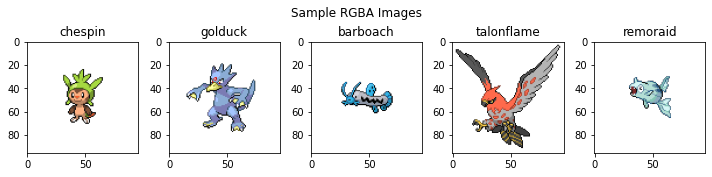

In [ ]:
# Sample images
plt.figure(figsize=(10,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  random = np.random.randint(1,data.shape[0])
  plt.imshow(data.loc[random,'imgs'])
  plt.title(data.loc[random,'names'])
plt.suptitle('Sample RGBA Images',y=0.75)
plt.tight_layout()
plt.show()

The images by default have 4 color channels (RGBA). We will explore two transformations: RGB conversion and YCbCr conversion.

In [ ]:
# RGB conversion
data_rgb = data.copy()
data_rgb['imgs'] = data_rgb['imgs'].apply(lambda x:cv2.cvtColor(x,cv2.COLOR_BGRA2RGB))
print('The RGB image dimension is {}.'.format(data_rgb.loc[1,'imgs'].shape))

The RGB image dimension is (96, 96, 3).


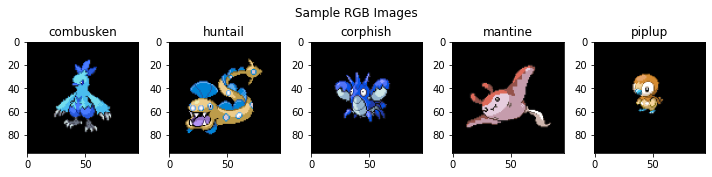

In [ ]:
# Sample RGB images
plt.figure(figsize=(10,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  random = np.random.randint(1,data_rgb.shape[0])
  plt.imshow(data_rgb.loc[random,'imgs'])
  plt.title(data_rgb.loc[random,'names'])
plt.suptitle('Sample RGB Images',y=0.75)
plt.tight_layout()
plt.show()

In [ ]:
# YCbCr conversion
data_ycc = data.copy()
data_ycc['imgs'] = data_ycc['imgs'].apply(lambda x:cv2.cvtColor(x,cv2.COLOR_BGRA2RGB))
data_ycc['imgs'] = data_ycc['imgs'].apply(lambda x:cv2.cvtColor(x,cv2.COLOR_BGR2YCR_CB))
print('The YCbCr image dimension is {}.'.format(data_ycc.loc[1,'imgs'].shape))

The YCbCr image dimension is (96, 96, 3).


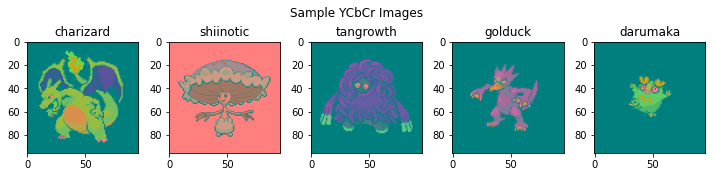

In [ ]:
# Sample YCbCr images
plt.figure(figsize=(10,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  random = np.random.randint(1,data_ycc.shape[0])
  plt.imshow(data_ycc.loc[random,'imgs'])
  plt.title(data_ycc.loc[random,'names'])
plt.suptitle('Sample YCbCr Images',y=0.75)
plt.tight_layout()
plt.show()

## 4. Dataset Scaling Decisions

We crop the image and keep only the center 32 by 32 square to pokemon size consistency. Otherwise, the clustering are overwhelmingly size based instead of color based.

In [ ]:
# Resize the images to 32 by 32
data_rgb_32 = data_rgb.copy()
data_rgb_32['imgs'] = data_rgb_32['imgs'].apply(lambda x:x[32:64,32:64])
data_rgb_32 = data_rgb_32.reset_index(drop=True)

data_ycc_32 = data_ycc.copy()
data_ycc_32['imgs'] = data_ycc_32['imgs'].apply(lambda x:x[32:64,32:64])
data_ycc_32 = data_ycc_32.reset_index(drop=True)

We also normalize the image pixel values to 0 mean and unit variance.

In [ ]:
# Normalization of RGB images
df_pixel_rgb_32 = pd.DataFrame(np.zeros((data_rgb_32.shape[0],len(data_rgb_32.loc[1,'imgs'].flatten()))),
                               columns=['feature'+str(i) for i in range(len(data_rgb_32.loc[0,'imgs'].flatten()))])

for i in range(data_rgb_32.shape[0]):
  try:
    df_pixel_rgb_32.iloc[i,:] = data_rgb_32.loc[i,'imgs'].reshape(-1,1).ravel()
  except:
    pass

data_rgb_32 = data_rgb_32.drop(columns='type2')
data_rgb_32 = data_rgb_32.rename(columns={'type1':'type'})

data_rgb_32 = pd.concat([data_rgb_32.iloc[:,:2],df_pixel_rgb_32],axis=1)

scaler_rgb = StandardScaler()
data_rgb_32_scaled = scaler_rgb.fit_transform(data_rgb_32.iloc[:,2:])
data_rgb_32_scaled = pd.DataFrame(data_rgb_32_scaled,columns=data_rgb_32.iloc[:,2:].columns)

In [ ]:
# Normalization of YCbCr images
df_pixel_ycc_32 = pd.DataFrame(np.zeros((data_ycc_32.shape[0],len(data_ycc_32.loc[1,'imgs'].flatten()))),
                               columns=['feature'+str(i) for i in range(len(data_ycc_32.loc[0,'imgs'].flatten()))])

for i in range(data_ycc_32.shape[0]):
  try:
    df_pixel_ycc_32.iloc[i,:] = data_ycc_32.loc[i,'imgs'].reshape(-1,1).ravel()
  except:
    pass

data_ycc_32 = data_ycc_32.drop(columns='type2')
data_ycc_32 = data_ycc_32.rename(columns={'type1':'type'})

data_ycc_32 = pd.concat([data_ycc_32.iloc[:,:2],df_pixel_ycc_32],axis=1)

scaler_ycc = StandardScaler()
data_ycc_32_scaled = scaler_ycc.fit_transform(data_ycc_32.iloc[:,2:])
data_ycc_32_scaled = pd.DataFrame(data_ycc_32_scaled,columns=data_ycc_32.iloc[:,2:].columns)

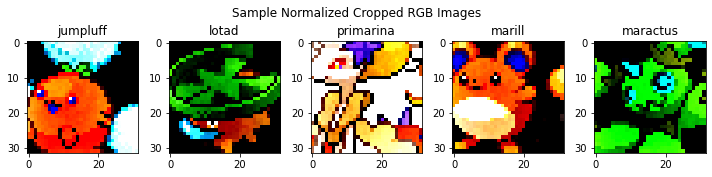

In [ ]:
# Sample normalized cropped RGB images 
plt.figure(figsize=(10,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  random = np.random.randint(1,data_rgb_32.shape[0])
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)
  plt.imshow(np.array(data_rgb_32_scaled.iloc[random,:]).reshape(32,32,3))
  logger.setLevel(old_level)
  plt.title(data_rgb_32.loc[random,'names'])
plt.suptitle('Sample Normalized Cropped RGB Images',y=0.75)
plt.tight_layout()
plt.show()

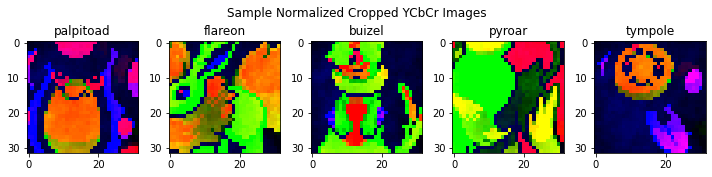

In [ ]:
# Sample normalized cropped YCbCr images 
plt.figure(figsize=(10,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  random = np.random.randint(1,data_ycc_32.shape[0])
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)
  plt.imshow(np.array(data_ycc_32_scaled.iloc[random,:]).reshape(32,32,3))
  logger.setLevel(old_level)
  plt.title(data_ycc_32.loc[random,'names'])
plt.suptitle('Sample Normalized Cropped YCbCr Images',y=0.75)
plt.tight_layout()
plt.show()

## 5. Clusterability and Clustering Structure Questions

**Principal Component Analysis - RGB**

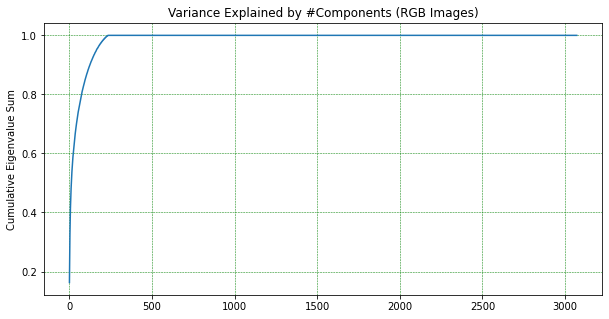

In [ ]:
# Get the cumulative principal component variance 
cov = np.cov(data_rgb_32_scaled.T) # covariance
l,v = np.linalg.eig(cov) # eigenvectors and eigenvalues
l_sort = np.sort(l)[::-1]
sort_order = np.argsort(l)[::-1]
df_loading_vecs = pd.DataFrame(v[sort_order],columns=['loading_vec_'+str(i) for i in range(len(v))]) # loading vectors
cum_var = np.round(np.cumsum(l_sort)/np.sum(l_sort),3) # variance explained 

# Visualze the outcome
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  plt.figure(figsize=(10,5))
  plt.plot(cum_var)
  plt.xticks(range(0,len(v),500))
  plt.ylabel('Cumulative Eigenvalue Sum')
  plt.grid(color='green',linestyle='--',linewidth=0.5)
  plt.title('Variance Explained by #Components (RGB Images)')
  plt.show()

In [ ]:
# Number of components needed to explain 70%,80%,90%,95% of variance
k70_rgb = np.min(np.where(cum_var>0.7))+1
k80_rgb = np.min(np.where(cum_var>0.8))+1
k90_rgb = np.min(np.where(cum_var>0.9))+1
k95_rgb = np.min(np.where(cum_var>0.95))+1
print('Need {}, {}, {}, {} components to explain 70%, 80%, 90%, and 95% of variance.'.format(k70_rgb,k80_rgb,k90_rgb,k95_rgb))

Need 44, 75, 126, 165 components to explain 70%, 80%, 90%, and 95% of variance.


To examine the clusterability of the data set, we appy t-SNE to the 165-component (95% variance explained) PCA output. 

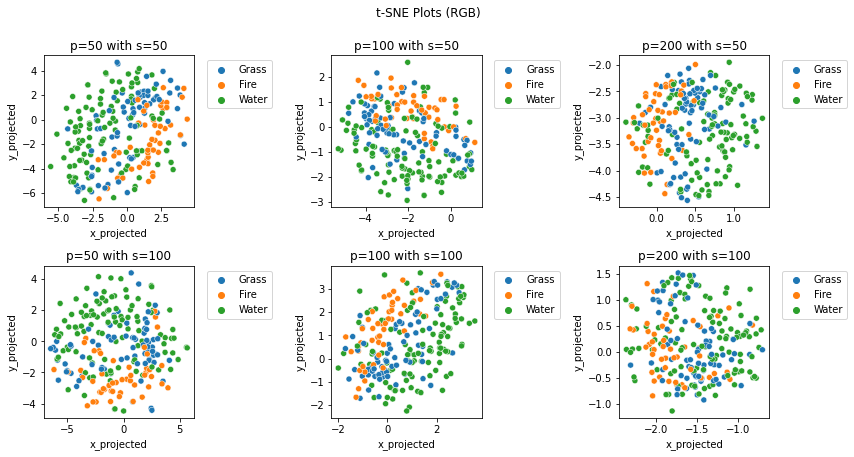

In [ ]:
# Set up a PCA and t-SNE pipeline 
plt.figure(figsize=(12,6))
count = 1
for s in [50,100]:
  for p in [50,100,200]:
    pca_tsne = Pipeline([('pca',PCA(n_components=k95_rgb,random_state=100)),
                         ('tsne',TSNE(n_components=2,perplexity=p,random_state=s))])

    with warnings.catch_warnings():
      warnings.filterwarnings('ignore')
      df_pca_tsne = pd.DataFrame(pca_tsne.fit_transform(data_rgb_32_scaled),columns=['x_projected','y_projected'])
      df_pca_tsne = pd.concat([labels_reduced,df_pca_tsne],axis=1)
      plt.subplot(2,3,count)
      sns.scatterplot(x='x_projected',y='y_projected',hue='type',data=df_pca_tsne)
      plt.title('p={} with s={}'.format(p,s))
      plt.legend(bbox_to_anchor=(1.05,1))
      count += 1

plt.suptitle('t-SNE Plots (RGB)',y=1.05)
plt.tight_layout()
plt.show()

The t-SNE plots fail to provide strong indication on the number of clusters we should use. It could be argued that there are 3 clusters poorly separated since some level of data concentrations can be observed. 

**Principal Component Analysis - YCbCr**

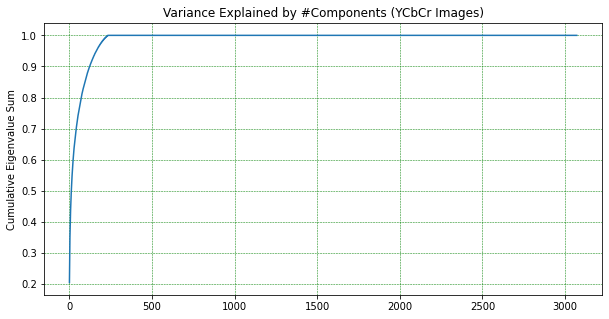

In [ ]:
# Get the cumulative principal component variance 
cov = np.cov(data_ycc_32_scaled.T) # covariance
l,v = np.linalg.eig(cov) # eigenvectors and eigenvalues
l_sort = np.sort(l)[::-1]
sort_order = np.argsort(l)[::-1]
df_loading_vecs = pd.DataFrame(v[sort_order],columns=['loading_vec_'+str(i) for i in range(len(v))]) # loading vectors
cum_var = np.round(np.cumsum(l_sort)/np.sum(l_sort),3) # variance explained 

# Visualze the outcome
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  plt.figure(figsize=(10,5))
  plt.plot(cum_var)
  plt.xticks(range(0,len(v),500))
  plt.ylabel('Cumulative Eigenvalue Sum')
  plt.grid(color='green',linestyle='--',linewidth=0.5)
  plt.title('Variance Explained by #Components (YCbCr Images)')
  plt.show()

In [ ]:
# Number of components needed to explain 70%,80%,90%,95% of variance
k70_ycc = np.min(np.where(cum_var>0.7))+1
k80_ycc = np.min(np.where(cum_var>0.8))+1
k90_ycc = np.min(np.where(cum_var>0.9))+1
k95_ycc = np.min(np.where(cum_var>0.95))+1
print('Need {}, {}, {}, {} components to explain 70%, 80%, 90%, and 95% of variance.'.format(k70_ycc,k80_ycc,k90_ycc,k95_ycc))

Need 43, 73, 124, 165 components to explain 70%, 80%, 90%, and 95% of variance.


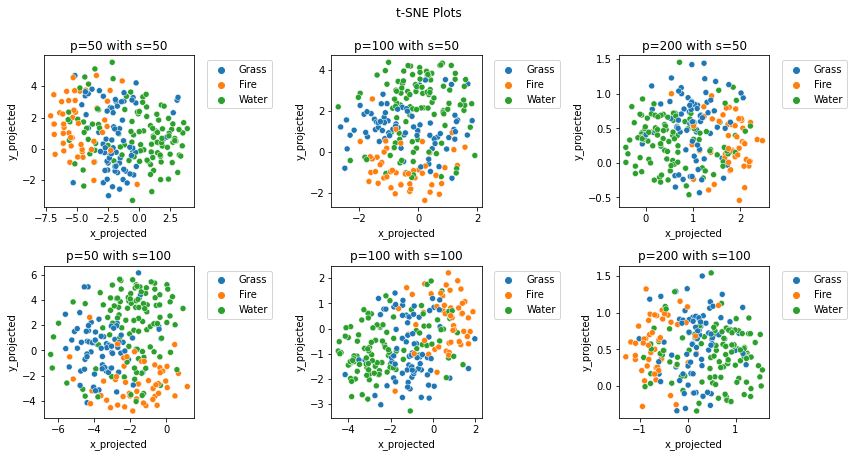

In [ ]:
# Set up a PCA and t-SNE pipeline 
plt.figure(figsize=(12,6))
count = 1
for s in [50,100]:
  for p in [50,100,200]:
    pca_tsne = Pipeline([('pca',PCA(n_components=k95_ycc,random_state=100)),
                         ('tsne',TSNE(n_components=2,perplexity=p,random_state=s))])

    with warnings.catch_warnings():
      warnings.filterwarnings('ignore')
      df_pca_tsne = pd.DataFrame(pca_tsne.fit_transform(data_ycc_32_scaled),columns=['x_projected','y_projected'])
      df_pca_tsne = pd.concat([labels_reduced,df_pca_tsne],axis=1)
      plt.subplot(2,3,count)
      sns.scatterplot(x='x_projected',y='y_projected',hue='type',data=df_pca_tsne)
      plt.title('p={} with s={}'.format(p,s))
      plt.legend(bbox_to_anchor=(1.05,1))
      count += 1

plt.suptitle('t-SNE Plots',y=1.05)
plt.tight_layout()
plt.show()

Cluster separation is more noticeable using YCbCr images. Once again, it seems that 3 is a decent candidate to be used as the number of clusters. For subsequent t-SNE analysis, we will use a perplexity value of 100 and random state 100.

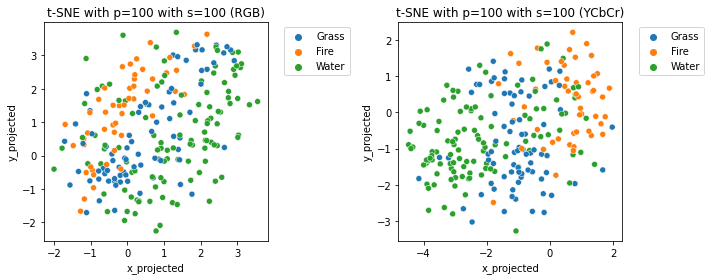

In [ ]:
# Final PCA and t-SNE pipeline
p = 100
s = 100
pca_tsne_rgb = Pipeline([('pca',PCA(n_components=k95_rgb,random_state=100)),
                         ('tsne',TSNE(n_components=2,perplexity=p,random_state=s))])

pca_tsne_ycc = Pipeline([('pca',PCA(n_components=k95_ycc,random_state=100)),
                         ('tsne',TSNE(n_components=2,perplexity=p,random_state=s))])

plt.figure(figsize=(10,4))
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  plt.subplot(1,2,1)
  df_pca_tsne_rgb = pd.DataFrame(pca_tsne_rgb.fit_transform(data_rgb_32_scaled),columns=['x_projected','y_projected'])
  df_pca_tsne_rgb = pd.concat([labels_reduced,df_pca_tsne_rgb],axis=1)
  sns.scatterplot(x='x_projected',y='y_projected',hue='type',data=df_pca_tsne_rgb)
  plt.title('t-SNE with p={} with s={} (RGB)'.format(p,s))
  plt.legend(bbox_to_anchor=(1.05,1))

  plt.subplot(1,2,2)
  df_pca_tsne_ycc = pd.DataFrame(pca_tsne_ycc.fit_transform(data_ycc_32_scaled),columns=['x_projected','y_projected'])
  df_pca_tsne_ycc = pd.concat([labels_reduced,df_pca_tsne_ycc],axis=1)
  sns.scatterplot(x='x_projected',y='y_projected',hue='type',data=df_pca_tsne_ycc)
  plt.title('t-SNE with p={} with s={} (YCbCr)'.format(p,s))
  plt.legend(bbox_to_anchor=(1.05,1))

plt.tight_layout()
plt.show()

## 6. Algorithm Selection Motivation

The first algorithm we choose is k-means due to the following reasons:

- All attributes are numerical.

K-means algorithm is relatively straightforward to implement without any involved parameter tuning. In our opinion, it's an ideal starting alogrithm for exploration purposes.

The second algorithm we implement is Gaussian mixture model since:

- The image data could be multimodal. 

- It allows for more flexible decision boundaries (ellipsodial vs. circular).

- It is probablistic in nature, which allows us to measure how strong our belief for each data point's cluster assignment. 

## 7. K-Means

### 7.1. Parameter Selection

The key parameter for k-means is the number of clusters. Although it is clear that 3 is a good candidate, we will still draw an elbow plot to confirm.

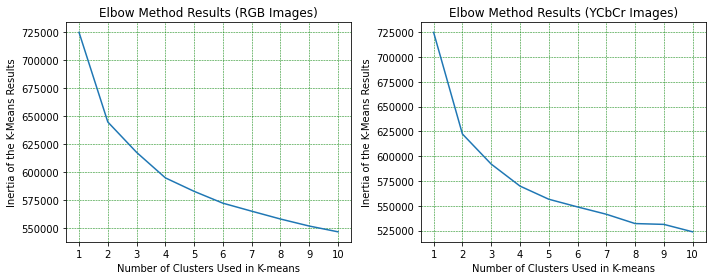

In [ ]:
# Apply K-means with different cluster numbers directly to the data
inertias_rgb = []
for k in range(1,11):
  model_rgb = KMeans(n_clusters=k,random_state=100)
  model_rgb.fit(data_rgb_32_scaled)
  inertias_rgb.append(model_rgb.inertia_)

inertias_ycc = []
for k in range(1,11):
  model_ycc = KMeans(n_clusters=k,random_state=100)
  model_ycc.fit(data_ycc_32_scaled)
  inertias_ycc.append(model_ycc.inertia_)

# Elbow plot
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(np.array([i for i in range(1,11)]),inertias_rgb)
plt.xlabel('Number of Clusters Used in K-means')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Inertia of the K-Means Results')
plt.grid(color='green',linestyle='--',linewidth=0.5)
plt.title('Elbow Method Results (RGB Images)')

plt.subplot(1,2,2)
plt.plot(np.array([i for i in range(1,11)]),inertias_ycc)
plt.xlabel('Number of Clusters Used in K-means')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Inertia of the K-Means Results')
plt.grid(color='green',linestyle='--',linewidth=0.5)
plt.title('Elbow Method Results (YCbCr Images)')

plt.tight_layout()
plt.show()

It can be argued that 2, 3, and 4 are all reasonable candidates for `n_clusters` based on the elbow plots.

### 7.2. Clustering Algorithm

In [ ]:
# Implement K-means with 3 clusters for both RGB and YCbCr images
kmeans_rgb = KMeans(n_clusters=3,random_state=100)
kmeans_rgb.fit(data_rgb_32_scaled)

kmeans_ycc = KMeans(n_clusters=3,random_state=100)
kmeans_ycc.fit(data_ycc_32_scaled)

KMeans(n_clusters=3, random_state=100)

### 7.3. Clustering Algorithm Results Presentation

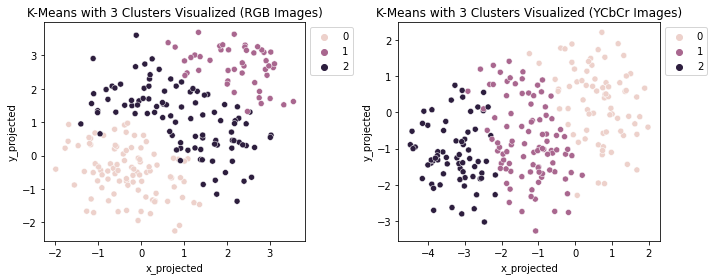

In [ ]:
# Visualize the 3-cluster K-means model output on the t-SNE plots
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
df_pca_tsne_rgb['predicted_cluster'] = kmeans_rgb.labels_
sns.scatterplot(x='x_projected',y='y_projected',hue='predicted_cluster',data=df_pca_tsne_rgb)
plt.title('K-Means with 3 Clusters Visualized (RGB Images)')
plt.legend(bbox_to_anchor=(1.2,1))

plt.subplot(1,2,2)
df_pca_tsne_ycc['predicted_cluster'] = kmeans_ycc.labels_
sns.scatterplot(x='x_projected',y='y_projected',hue='predicted_cluster',data=df_pca_tsne_ycc)
plt.title('K-Means with 3 Clusters Visualized (YCbCr Images)')
plt.legend(bbox_to_anchor=(1.2,1))

plt.tight_layout()
plt.show()

The algorithm is able to identify 3 clusters that roughly matches the pre-assigned labels when using YCbCr images. Same cannot be said for RGB images. 


### 7.4. Assessing Clustering Separation and Cohesion

In [ ]:
# Silhouette score
sil_score_rgb = silhouette_score(data_rgb_32_scaled,df_pca_tsne_rgb['predicted_cluster'])
sil_score_ycc = silhouette_score(data_ycc_32_scaled,df_pca_tsne_ycc['predicted_cluster'])

print('The Silhouette score with RGB images is {}.'.format(round(sil_score_rgb,4)))
print('The Silhouette score with YCbCr images is {}.'.format(round(sil_score_ycc,4)))

The Silhouette score with RGB images is 0.0552.
The Silhouette score with YCbCr images is 0.0608.


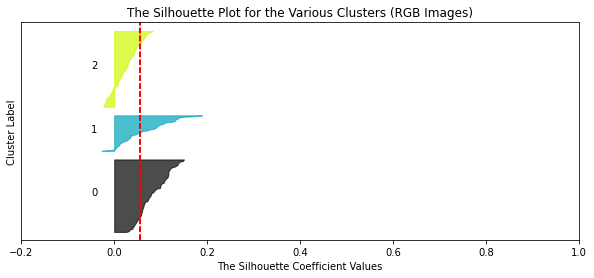

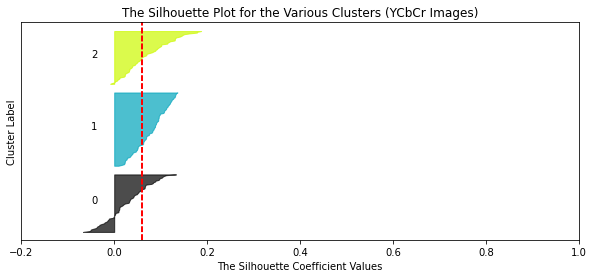

In [ ]:
# Silhouette plots
def show_silhouette_plots(X,cluster_labels,title):
  n_clusters = len(np.unique(cluster_labels))    

  f,a = plt.subplots(1,1,figsize=(10,4))

  a.set_xlim([-0.1, 1])
  a.set_ylim([0,len(X)+(n_clusters+1)*10])

  silhouette_avg = silhouette_score(X,cluster_labels)

  sample_silhouette_values = silhouette_samples(X,cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      ith_cluster_silhouette_values=\
          sample_silhouette_values[cluster_labels==i]
  

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower+size_cluster_i

      color = cm.nipy_spectral(float(i)/n_clusters)
      a.fill_betweenx(np.arange(y_lower,y_upper),
                        0,ith_cluster_silhouette_values,
                        facecolor=color,edgecolor=color,alpha=0.7)

      a.text(-0.05,y_lower+0.5*size_cluster_i,str(i))

      y_lower = y_upper+10  

      a.set_title('The Silhouette Plot for the Various Clusters'+' '+title)
      a.set_xlabel('The Silhouette Coefficient Values')
      a.set_ylabel('Cluster Label')

      a.axvline(x=silhouette_avg,color="red",linestyle="--")

      a.set_yticks([]) 
      a.set_xticks([-0.2,0,0.2,0.4,0.6,0.8,1.0])

  plt.show()
  return

show_silhouette_plots(data_rgb_32_scaled,kmeans_rgb.labels_,'(RGB Images)')
show_silhouette_plots(data_ycc_32_scaled,kmeans_ycc.labels_,'(YCbCr Images)')

The silhouette scores of the clustering are relatively low. It's clear that the clusters do not have strong inter-cluster separation and intra-cluster cohesion.

### 7.5. Additional Analysis

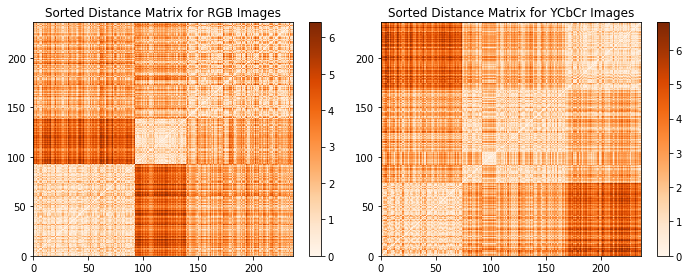

In [ ]:
# Distance matrix
df_pca_tsne_sorted_rgb = df_pca_tsne_rgb.sort_values(by=['predicted_cluster'])
df_pca_tsne_sorted_rgb = df_pca_tsne_sorted_rgb.reset_index(drop=True)
dm_rgb = squareform(pdist(df_pca_tsne_sorted_rgb.iloc[:,1:3],metric='euclidean'))

df_pca_tsne_sorted_ycc = df_pca_tsne_ycc.sort_values(by=['predicted_cluster'])
df_pca_tsne_sorted_ycc = df_pca_tsne_sorted_ycc.reset_index(drop=True)
dm_ycc = squareform(pdist(df_pca_tsne_sorted_ycc.iloc[:,1:3],metric='euclidean'))

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.pcolormesh(dm_rgb,cmap='Oranges')
plt.colorbar()
plt.title('Sorted Distance Matrix for RGB Images')

plt.subplot(1,2,2)
plt.pcolormesh(dm_ycc,cmap='Oranges')
plt.colorbar()
plt.title('Sorted Distance Matrix for YCbCr Images')

plt.tight_layout()
plt.show()

In [ ]:
# Correlation with the ideal distance matrix - RGB images
min_dist_rgb = np.min(dm_rgb)
max_dist_rgb = np.max(dm_rgb)
dm_scaled_rgb = 1-(dm_rgb-min_dist_rgb)/(max_dist_rgb-min_dist_rgb) # scaled distance matrix

cluster_sizes_rgb = df_pca_tsne_rgb['predicted_cluster'].value_counts().sort_index()
block_list_rgb = []
for i in cluster_sizes_rgb:
  block = np.ones((i,i)).tolist()
  block_list_rgb.append(block)

ideal_dm_rgb = block_diag(block_list_rgb[0],block_list_rgb[1],block_list_rgb[2]) # ideal distance matrix

dm_scaled_flat_rgb = dm_scaled_rgb.flatten()
ideal_dm_flat_rgb = ideal_dm_rgb.flatten()
np.corrcoef(dm_scaled_flat_rgb,ideal_dm_flat_rgb)

array([[1.        , 0.55022289],
       [0.55022289, 1.        ]])

In [ ]:
# Correlation with the ideal distance matrix - YCbCr images
min_dist_ycc = np.min(dm_ycc)
max_dist_ycc = np.max(dm_ycc)
dm_scaled_ycc = 1-(dm_ycc-min_dist_ycc)/(max_dist_ycc-min_dist_ycc) # scaled distance matrix

# Ideal Distance matrix
cluster_sizes_ycc = df_pca_tsne_ycc['predicted_cluster'].value_counts().sort_index()
block_list_ycc = []
for i in cluster_sizes_ycc:
  block = np.ones((i,i)).tolist()
  block_list_ycc.append(block)

ideal_dm_ycc = block_diag(block_list_ycc[0],block_list_ycc[1],block_list_ycc[2]) # ideal distance matrix

# Correlation
dm_scaled_flat_ycc = dm_scaled_ycc.flatten()
ideal_dm_flat_ycc = ideal_dm_ycc.flatten()
np.corrcoef(dm_scaled_flat_ycc,ideal_dm_flat_ycc)

array([[1.        , 0.57001009],
       [0.57001009, 1.        ]])

The correlation values indicate not-particularly-strong separation and cohesion.

In [ ]:
rand_score_rgb = adjusted_rand_score(labels_reduced,df_pca_tsne_rgb['predicted_cluster'])
rand_score_ycc = adjusted_rand_score(labels_reduced,df_pca_tsne_ycc['predicted_cluster'])

print('The adjusted Rand score of k-means with RGB images is {}.'.format(round(rand_score_rgb,4)))
print('The adjusted Rand score of k-means with YCbCr images is {}.'.format(round(rand_score_ycc,4)))

The adjusted Rand score of k-means with RGB images is 0.0039.
The adjusted Rand score of k-means with YCbCr images is 0.2598.


The adjusted Rand score confirms the observation that the clustering output using YCbCr images matches the real label better than the clustering using RGB images.

### 7.6. Describing Each of the Clusters

In [ ]:
# Obtain the cluster centers
kmeans_centers_rgb = kmeans_rgb.cluster_centers_
kmeans_centers_rgb = scaler_rgb.inverse_transform(kmeans_centers_rgb)

kmeans_centers_ycc = kmeans_ycc.cluster_centers_
kmeans_centers_ycc = scaler_ycc.inverse_transform(kmeans_centers_ycc)

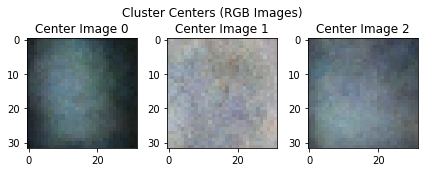

In [ ]:
# Visualize the cluster center - RGB images
for i in range(3):
  plt.subplot(1,3,i+1)
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)
  img_center_rgb = kmeans_centers_rgb[i].reshape(-1,1)
  plt.imshow(img_center_rgb.reshape((32,32,3)))
  logger.setLevel(old_level)
  plt.title('Center Image '+str(i))

plt.suptitle('Cluster Centers (RGB Images)',y=0.8)
plt.tight_layout()
plt.show()

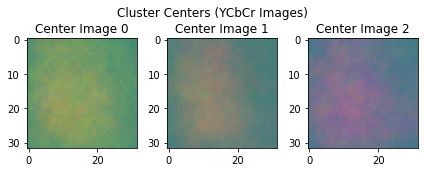

In [ ]:
# Visualize the cluster center - YCbCr images
for i in range(3):
  plt.subplot(1,3,i+1)
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)
  img_center_ycc = kmeans_centers_ycc[i].reshape(-1,1)
  plt.imshow(img_center_ycc.reshape((32,32,3)))
  logger.setLevel(old_level)
  plt.title('Center Image '+str(i))

plt.suptitle('Cluster Centers (YCbCr Images)',y=0.8)
plt.tight_layout()
plt.show()

The separation criterion with YCbCr images seems to be the color-related.

In [ ]:
# Percentage of primary types in each cluster - RGB images
df_labels_kmeans_rgb = pd.concat([labels_reduced,df_pca_tsne_rgb['predicted_cluster']],axis=1)

percents_rgb = {}
for i in range(3):
  df_i = df_labels_kmeans_rgb[df_labels_kmeans_rgb.predicted_cluster==i]
  percents_i = []
  for l in df_labels_kmeans_rgb['type'].unique():
    percents_i.append(df_i[df_i.type==l].shape[0]/df_i.shape[0])
  percents_rgb['cluster_'+str(i)] = percents_i

df_kmeans_summary_rgb = pd.DataFrame(percents_rgb)

# Percentage of primary types in each cluster - YCbCr images
df_labels_kmeans_ycc = pd.concat([labels_reduced,df_pca_tsne_ycc['predicted_cluster']],axis=1)

percents_ycc = {}
for i in range(3):
  df_i = df_labels_kmeans_ycc[df_labels_kmeans_ycc.predicted_cluster==i]
  percents_i = []
  for l in df_labels_kmeans_ycc['type'].unique():
    percents_i.append(df_i[df_i.type==l].shape[0]/df_i.shape[0])
  percents_ycc['cluster_'+str(i)] = percents_i

df_kmeans_summary_ycc = pd.DataFrame(percents_ycc)

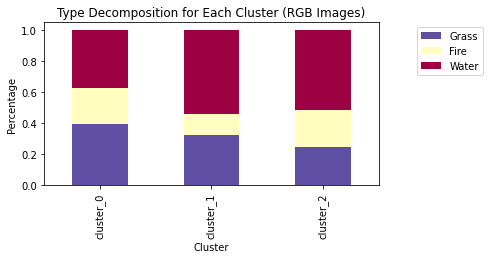

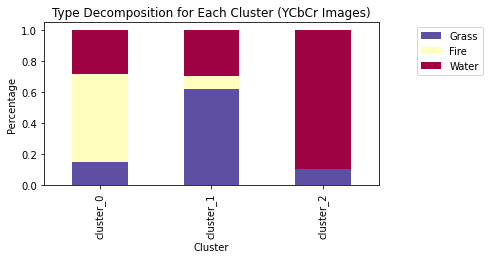

In [ ]:
# Plot the summary
df_kmeans_summary_rgb.T.plot(kind='bar',stacked=True,figsize=(6,3),cmap=plt.cm.Spectral_r)
plt.title('Type Decomposition for Each Cluster (RGB Images)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend([i for i in df_labels_kmeans_rgb['type'].unique()],bbox_to_anchor=(1.1,1))
plt.show()

df_kmeans_summary_ycc.T.plot(kind='bar',stacked=True,figsize=(6,3),cmap=plt.cm.Spectral_r)
plt.title('Type Decomposition for Each Cluster (YCbCr Images)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend([i for i in df_labels_kmeans_ycc['type'].unique()],bbox_to_anchor=(1.1,1))
plt.show()

We have one of the three types being dominant in each cluster. While not perferct, we conclude that k-means can recognize the color palette differences between the pokemons when the images are YCbCr based. And there exists some visual commonalities among pokemons of the same type.

Suppose points in cluster 0, 1, and 2 represent a prediction of fire, grass, and water type respectively. We caculate the accuracy score of the clustering using YCbCr images.

In [ ]:
dict_kmeans = {0:'Fire',1:'Grass',2:'Water'}
df_pca_tsne_ycc['predicted_label'] = df_pca_tsne_ycc['predicted_cluster'].map(dict_kmeans)
acc_score_kmeans_ycc = accuracy_score(labels_reduced,df_pca_tsne_ycc['predicted_label'])
print('Accuracy score of k-means using YCbCr images is {}.'.format(round(acc_score_kmeans_ycc,4)))

Accuracy score of k-means using YCbCr images is 0.6822.


## 8. Gaussian Mixture Model

### 8.1. Parameter Selection

First, we assess the number of clusters using AIC and BIC. We implement the Gaussian mixture model on the PCA output to reduce computational cost.

Since Gaussian mixture tends to converge quickly to a local minimum, we initialize the model with k-means. 

In [ ]:
# Set up a range of cluster numbers to try
k_range = range(2,16)

# Create empty lists to store the AIC and BIC values
aic_score_rgb = []
bic_score_rgb = []
aic_score_ycc = []
bic_score_ycc = []

pca_output_rgb = PCA(n_components=k95_rgb,random_state=100).fit_transform(data_rgb_32_scaled)
pca_output_ycc = PCA(n_components=k95_ycc,random_state=100).fit_transform(data_ycc_32_scaled)

# Loop through the range and fit a model
for k in k_range:
    gm_rgb = GaussianMixture(n_components=k,random_state=100,max_iter=1000)
    gm_ycc = GaussianMixture(n_components=k,random_state=100,max_iter=1000)

    gm_rgb.fit(pca_output_rgb)
    gm_ycc.fit(pca_output_ycc)
    
    aic_score_rgb.append(gm_rgb.aic(pca_output_rgb))
    bic_score_rgb.append(gm_rgb.bic(pca_output_rgb))
    aic_score_ycc.append(gm_ycc.aic(pca_output_ycc))
    bic_score_ycc.append(gm_ycc.bic(pca_output_ycc))

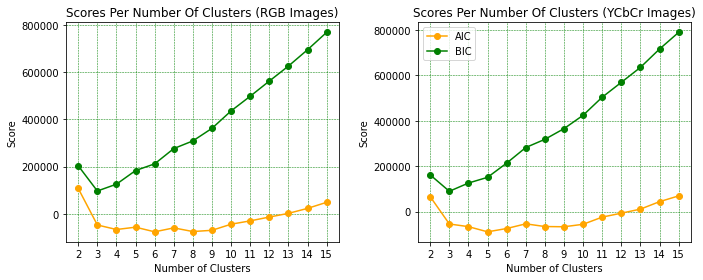

In [ ]:
# Plot the AIC and BIC values together
f,a = plt.subplots(1,2,figsize=(10,4))
a[0].plot(k_range, aic_score_rgb, '-o', color='orange',label='AIC')
a[0].plot(k_range, bic_score_rgb, '-o', color='green',label='BIC')
a[0].set(xlabel='Number of Clusters', ylabel='Score')
a[0].set_xticks(k_range)
a[0].set_title('Scores Per Number Of Clusters (RGB Images)')
a[0].grid(color='green',linestyle='--',linewidth=0.5)

a[1].plot(k_range, aic_score_ycc, '-o', color='orange',label='AIC')
a[1].plot(k_range, bic_score_ycc, '-o', color='green',label='BIC')
a[1].set(xlabel='Number of Clusters', ylabel='Score')
a[1].set_xticks(k_range)
a[1].set_title('Scores Per Number Of Clusters (YCbCr Images)')
a[1].grid(color='green',linestyle='--',linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()

The scores are meant to be minimized. While the two have different trends, we prioritize BIC score and choose 3 as the number of clusters for both cases.

### 8.2. Clustering Algorithm

In [ ]:
# Implement Gaussian mixture with 3 clusters
gm_rgb = GaussianMixture(n_components=3,random_state=100,max_iter=1000)
gm_ycc = GaussianMixture(n_components=3,random_state=100,max_iter=1000)

gm_rgb.fit(data_rgb_32_scaled)
gm_ycc.fit(data_ycc_32_scaled)

# Membership weight
W_rgb = gm_rgb.predict_proba(data_rgb_32_scaled)
W_ycc = gm_ycc.predict_proba(data_ycc_32_scaled)

### 8.3. Clustering Algorithm Results Presentation

In [ ]:
cluster_cols_rgb = ['Cluster %s Membership Score'%str(i) for i in range(3)]
cluster_cols_ycc = ['Cluster %s Membership Score'%str(i) for i in range(3)]

df_membership_rgb = pd.DataFrame(W_rgb,columns=cluster_cols_rgb)
df_membership_ycc = pd.DataFrame(W_ycc,columns=cluster_cols_ycc)

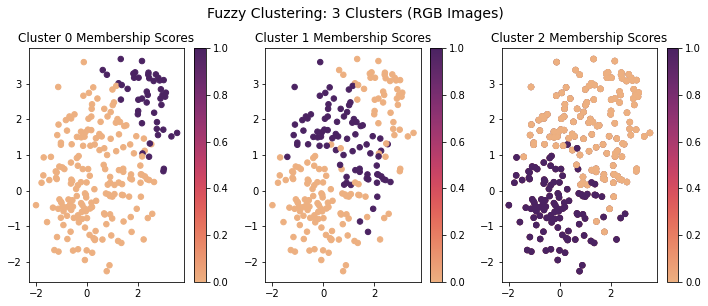

In [ ]:
c = 3

f,a = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
  df_pca_tsne_rgb['cluster %s membership score'%str(i)] = df_membership_rgb['Cluster %s Membership Score'%(str(i))]

  points = plt.scatter(df_pca_tsne_rgb['x_projected'],df_pca_tsne_rgb['y_projected'],
                       c=df_pca_tsne_rgb['cluster %s membership score'%str(i)],s=30,cmap='flare',vmin=0,vmax=1)
  
  a[i].scatter(df_pca_tsne_rgb['x_projected'],df_pca_tsne_rgb['y_projected'],
               c=df_pca_tsne_rgb['cluster %s membership score'%str(i)],s=30,cmap='flare',vmin=0,vmax=1)
  
  f.colorbar(points,ax=a[i])

  a[i].set_title('Cluster %s Membership Scores'%(str(i)))

plt.suptitle('Fuzzy Clustering: %s Clusters (RGB Images)'%(c),fontsize=14,y=1.05)
plt.tight_layout()
plt.show()

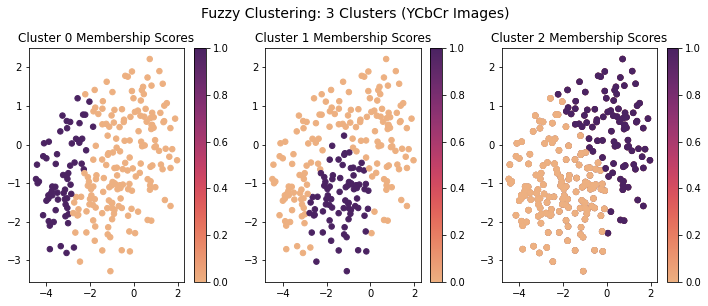

In [ ]:
c = 3

f,a = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
  df_pca_tsne_ycc['cluster %s membership score'%str(i)] = df_membership_ycc['Cluster %s Membership Score'%(str(i))]

  points = plt.scatter(df_pca_tsne_ycc['x_projected'],df_pca_tsne_ycc['y_projected'],
                       c=df_pca_tsne_ycc['cluster %s membership score'%str(i)],s=30,cmap='flare',vmin=0,vmax=1)
  
  a[i].scatter(df_pca_tsne_ycc['x_projected'],df_pca_tsne_ycc['y_projected'],
               c=df_pca_tsne_ycc['cluster %s membership score'%str(i)],s=30,cmap='flare',vmin=0,vmax=1)
  
  f.colorbar(points,ax=a[i])

  a[i].set_title('Cluster %s Membership Scores'%(str(i)))

plt.suptitle('Fuzzy Clustering: %s Clusters (YCbCr Images)'%(c),fontsize=14,y=1.05)
plt.tight_layout()
plt.show()

Comparing with the true labels, the clustering output using YCbCr images yield better result than RGB images.

### 8.4. Assessing Clustering Separation and Cohesion

In [ ]:
# Silhouette score
data_gauss_rgb = data_rgb_32_scaled.copy()
data_gauss_rgb['predicted_cluster'] = gm_rgb.predict(data_gauss_rgb)
df_avg_rgb = data_gauss_rgb.groupby('predicted_cluster').mean()
sil_score_rgb = silhouette_score(data_rgb_32_scaled,data_gauss_rgb['predicted_cluster'])

data_gauss_ycc = data_ycc_32_scaled.copy()
data_gauss_ycc['predicted_cluster'] = gm_ycc.predict(data_gauss_ycc)
df_avg_ycc = data_gauss_ycc.groupby('predicted_cluster').mean()
sil_score_ycc = silhouette_score(data_ycc_32_scaled,data_gauss_ycc['predicted_cluster'])

print('The Silhouette score with RGB images is {}.'.format(round(sil_score_rgb,4)))
print('The Silhouette score with YCbCr images is {}.'.format(round(sil_score_ycc,4)))

The Silhouette score with RGB images is 0.059.
The Silhouette score with YCbCr images is 0.0574.


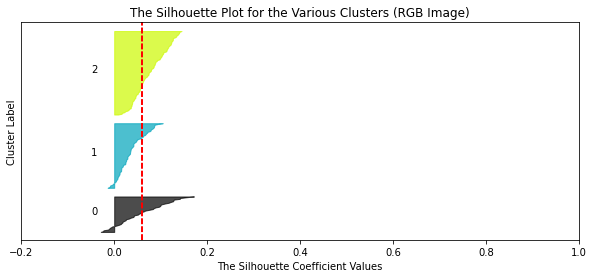

In [ ]:
show_silhouette_plots(data_rgb_32_scaled,data_gauss_rgb['predicted_cluster'],'(RGB Image)')

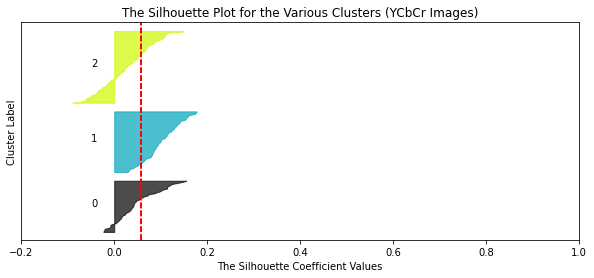

In [ ]:
show_silhouette_plots(data_ycc_32_scaled,data_gauss_ycc['predicted_cluster'],'(YCbCr Images)')

Silhouette score indicates slightly worse performance compared with k-means. There are more points with negative score. 

### 8.5. Additional Analysis

In [ ]:
rand_score_rgb = adjusted_rand_score(labels_reduced,data_gauss_rgb['predicted_cluster'])
rand_score_ycc = adjusted_rand_score(labels_reduced,data_gauss_ycc['predicted_cluster'])

print('The adjusted Rand score with RGB images is {}.'.format(round(rand_score_rgb,4)))
print('The adjusted Rand score with YCbCr images is {}.'.format(round(rand_score_ycc,4)))

The adjusted Rand score with RGB images is 0.002.
The adjusted Rand score with YCbCr images is 0.1914.


We obtain a lower Rand score, which indicates more disagreement between the pre-assignment pokemon types and the clustering outcome.

### 8.6. Describing Each of the Clusters

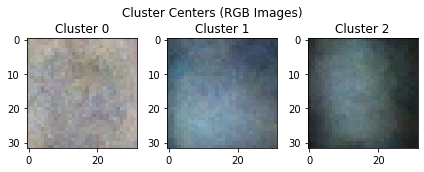

In [ ]:
# Cluster center images - RGB images
for i in range(3):
  plt.subplot(1,3,i+1)
  obj_img_rgb = scaler_rgb.inverse_transform(np.array(df_avg_rgb))[i].reshape((32,32,3))
  plt.title('Cluster {}'.format(i))
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)
  plt.imshow(obj_img_rgb)
  logger.setLevel(old_level)

plt.suptitle('Cluster Centers (RGB Images)',y=0.8)
plt.tight_layout()
plt.show()

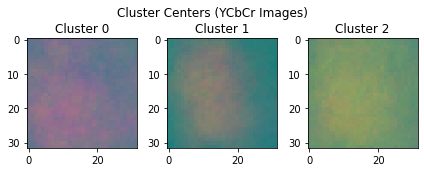

In [ ]:
# Cluster center images - YCbCr images
for i in range(3):
  plt.subplot(1,3,i+1)
  obj_img_ycc = scaler_ycc.inverse_transform(np.array(df_avg_ycc))[i].reshape((32,32,3))
  plt.title('Cluster {}'.format(i))
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)
  plt.imshow(obj_img_ycc)
  logger.setLevel(old_level)

plt.suptitle('Cluster Centers (YCbCr Images)',y=0.8)
plt.tight_layout()
plt.show()

In [ ]:
# Percentage of primary types in each cluster - RGB images
df_labels_gm_rgb = pd.concat([labels_reduced,data_gauss_rgb['predicted_cluster']],axis=1)

percents_rgb = {}
for i in range(3):
  df_i = df_labels_gm_rgb[df_labels_gm_rgb.predicted_cluster==i]
  percents_i = []
  for l in df_labels_gm_rgb['type'].unique():
    percents_i.append(df_i[df_i.type==l].shape[0]/df_i.shape[0])
  percents_rgb['cluster_'+str(i)] = percents_i

df_gm_summary_rgb = pd.DataFrame(percents_rgb)

# Percentage of primary types in each cluster - YCbCr images
df_labels_gm_ycc = pd.concat([labels_reduced,data_gauss_ycc['predicted_cluster']],axis=1)

percents_ycc = {}
for i in range(3):
  df_i = df_labels_gm_ycc[df_labels_gm_ycc.predicted_cluster==i]
  percents_i = []
  for l in df_labels_gm_ycc['type'].unique():
    percents_i.append(df_i[df_i.type==l].shape[0]/df_i.shape[0])
  percents_ycc['cluster_'+str(i)] = percents_i

df_gm_summary_ycc = pd.DataFrame(percents_ycc)

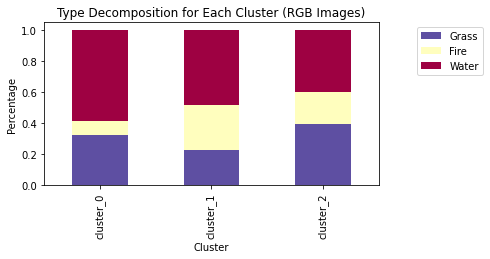

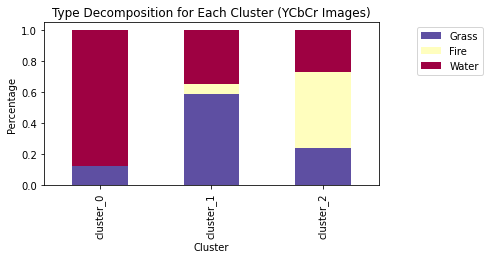

In [ ]:
# Plot the summary
df_gm_summary_rgb.T.plot(kind='bar',stacked=True,figsize=(6,3),cmap=plt.cm.Spectral_r)
plt.title('Type Decomposition for Each Cluster (RGB Images)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend([i for i in df_labels_gm_rgb['type'].unique()],bbox_to_anchor=(1.1,1))
plt.show()

df_gm_summary_ycc.T.plot(kind='bar',stacked=True,figsize=(6,3),cmap=plt.cm.Spectral_r)
plt.title('Type Decomposition for Each Cluster (YCbCr Images)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend([i for i in df_labels_gm_rgb['type'].unique()],bbox_to_anchor=(1.1,1))
plt.show()

We end up with almost identical label distribution within each cluster compared with k-means.

Suppose points in cluster 0, 1, and 2 represent a prediction of water, grass, and fire type respectively. We caculate the accuracy score of the clustering using YCbCr images.

In [ ]:
dict_ycc = {0:'Water',1:'Grass',2:'Fire'}
data_gauss_ycc['predicted_label'] = data_gauss_ycc['predicted_cluster'].map(dict_ycc)
acc_score_gm_ycc = accuracy_score(labels_reduced,data_gauss_ycc['predicted_label'])
print('Accuracy score of Gaussian mixture using YCbCr images is {}.'.format(round(acc_score_gm_ycc,4)))

Accuracy score of Gaussian mixture using YCbCr images is 0.6314.


## 9. Supervised Learning - Support Vector Machine

### 9.1. Data Preparation

In [ ]:
# Normalization of RGB images
df_pixel_rgb = pd.DataFrame(np.zeros((data_rgb.shape[0],len(data_rgb.loc[1,'imgs'].flatten()))),
                            columns=['feature'+str(i) for i in range(len(data_rgb.loc[0,'imgs'].flatten()))])

for i in range(data_rgb.shape[0]):
  try:
    df_pixel_rgb.iloc[i,:] = data_rgb.loc[i,'imgs'].reshape(-1,1).ravel()
  except:
    pass

data_rgb_raw = data_rgb.copy()
data_rgb_raw = data_rgb_raw.drop(columns='type2')
data_rgb_raw = data_rgb_raw.rename(columns={'type1':'type'})

data_rgb_raw = pd.concat([data_rgb_raw.iloc[:,:2],df_pixel_rgb],axis=1)

scaler_rgb_raw = StandardScaler()
data_rgb_scaled = scaler_rgb_raw.fit_transform(data_rgb_raw.iloc[:,2:])
data_rgb_scaled = pd.DataFrame(data_rgb_scaled,columns=data_rgb_raw.iloc[:,2:].columns)

In [ ]:
# Normalization of YCbCr images
df_pixel_ycc = pd.DataFrame(np.zeros((data_ycc.shape[0],len(data_ycc.loc[1,'imgs'].flatten()))),
                            columns=['feature'+str(i) for i in range(len(data_ycc.loc[0,'imgs'].flatten()))])

for i in range(data_ycc.shape[0]):
  try:
    df_pixel_ycc.iloc[i,:] = data_ycc.loc[i,'imgs'].reshape(-1,1).ravel()
  except:
    pass

data_ycc_raw = data_ycc.copy()
data_ycc_raw = data_ycc_raw.drop(columns='type2')
data_ycc_raw = data_ycc_raw.rename(columns={'type1':'type'})

data_ycc_raw = pd.concat([data_ycc_raw.iloc[:,:2],df_pixel_ycc],axis=1)

scaler_ycc_raw = StandardScaler()
data_ycc_scaled = scaler_ycc_raw.fit_transform(data_ycc_raw.iloc[:,2:])
data_ycc_scaled = pd.DataFrame(data_ycc_scaled,columns=data_ycc_raw.iloc[:,2:].columns)

In [ ]:
# Train test split
data_scaled_rgb_train,data_scaled_rgb_test,labels_rgb_train,labels_rgb_test = train_test_split(np.array(data_rgb_scaled),np.array(labels_reduced),
                                                                                               test_size=0.2,random_state=100,stratify=np.array(labels_reduced))

data_scaled_ycc_train,data_scaled_ycc_test,labels_ycc_train,labels_ycc_test = train_test_split(np.array(data_ycc_scaled),np.array(labels_reduced),
                                                                                               test_size=0.2,random_state=100,stratify=np.array(labels_reduced))

### 9.2. Model Implementation

In [ ]:
# Implementation
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  model_svc_rgb = SVC(random_state=100,kernel='rbf',C=2)
  model_svc_ycc = SVC(random_state=100,kernel='rbf',C=2)

  model_svc_rgb.fit(data_scaled_rgb_train,labels_rgb_train.ravel())
  model_svc_ycc.fit(data_scaled_ycc_train,labels_ycc_train.ravel())

  svc_pred_rgb = model_svc_rgb.predict(data_scaled_rgb_test)
  svc_pred_ycc = model_svc_ycc.predict(data_scaled_ycc_test)

### 9.3. Performance Assessment

In [ ]:
# Performance report - RGB images
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  svc_report_rgb = classification_report(labels_rgb_test.ravel(),svc_pred_rgb,digits=4)
  print(svc_report_rgb)

              precision    recall  f1-score   support

        Fire     0.8000    0.8000    0.8000        10
       Grass     0.7857    0.6875    0.7333        16
       Water     0.7500    0.8182    0.7826        22

    accuracy                         0.7708        48
   macro avg     0.7786    0.7686    0.7720        48
weighted avg     0.7723    0.7708    0.7698        48



In [ ]:
# Performance report - YCbCr images
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  svc_report_ycc = classification_report(labels_ycc_test.ravel(),svc_pred_ycc,digits=4)
  print(svc_report_ycc)

              precision    recall  f1-score   support

        Fire     0.6154    0.8000    0.6957        10
       Grass     0.7692    0.6250    0.6897        16
       Water     0.6818    0.6818    0.6818        22

    accuracy                         0.6875        48
   macro avg     0.6888    0.7023    0.6890        48
weighted avg     0.6971    0.6875    0.6873        48



In our experiments, support vector machine model with RGB images performs better in pokemon type classification. With YCbCr images, k-means achieves similar performance to support vector machine.

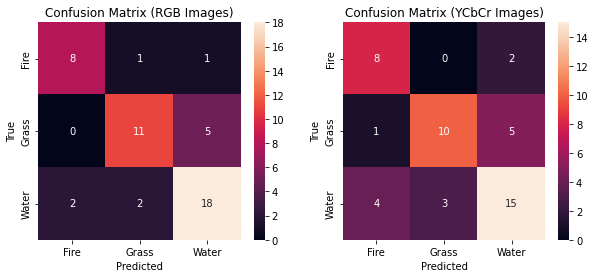

In [ ]:
# Confusion matrix
labels = np.array(['Fire','Grass','Water'])
cm_rgb = confusion_matrix(labels_rgb_test,svc_pred_rgb)
cm_ycc = confusion_matrix(labels_ycc_test,svc_pred_ycc)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap(cm_rgb,annot=True,fmt='g',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (RGB Images)')

plt.subplot(1,2,2)
sns.heatmap(cm_ycc,annot=True,fmt='g',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (YCbCr Images)')

plt.show()

## 10. Deep Learning - Convolutional Neural Network

### 10.1. Network Specification

In [ ]:
# Convolutional neural network
class CNN(nn.Module):
  def __init__(self,input_dims):
    super().__init__()
    self.pool = nn.MaxPool2d(2,2)
    self.conv1 = nn.Conv2d(input_dims[0],32,kernel_size=3,stride=1,padding=1)
    self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
    self.conv3 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)

    fc_input_dims = self.calculate_cov_output_dims(input_dims)

    self.fc1 = nn.Linear(fc_input_dims,512)
    self.fc2 = nn.Linear(512,3)
  
  def calculate_cov_output_dims(self,input_dims):
    x = torch.zeros(1,*input_dims)
    dims = self.pool(self.conv1(x))
    dims = self.pool(self.conv2(dims))
    dims = self.pool(self.conv3(dims))
    return int(np.prod(dims.size()))
  
  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = torch.flatten(x,1)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
# Network architecture
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN(input_dims=(3,96,96)).to(device)
summary(model,(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
         MaxPool2d-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          36,928
         MaxPool2d-6             [-1, 64, 6, 6]               0
            Linear-7                  [-1, 512]       1,180,160
            Linear-8                    [-1, 3]           1,539
Total params: 1,238,019
Trainable params: 1,238,019
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 3.26
Params size (MB): 4.72
Estimated Total Size (MB): 8.08
----------------------------------------------------------------


### 10.2. Data Preparation

In [ ]:
# Train test split
data_train,data_test,labels_train,labels_test = train_test_split(np.array(data.iloc[:,0]),np.array(labels_reduced),
                                                                 test_size=0.2,random_state=100,stratify=np.array(labels_reduced))

data = data.reset_index(drop=True)
train_indices = [i for i in range(data.shape[0]) if data.loc[i,'names'] in data_train]
test_indices = [i for i in range(data.shape[0]) if data.loc[i,'names'] not in data_train]

data_train = data.iloc[train_indices,:].reset_index(drop=True)
data_train = data_train[['names','type1','type2']]
data_test = data.iloc[test_indices,:].reset_index(drop=True)
data_test = data_test[['names','type1','type2']]

data_path = os.getcwd()+'/drive/MyDrive/pokedex/'

In [ ]:
if os.path.isdir(os.getcwd()+'/train'):
  shutil.rmtree(os.getcwd()+'/train')
if os.path.isdir(os.getcwd()+'/test'):
  shutil.rmtree(os.getcwd()+'/test')

# Create folders in current directory
os.mkdir(os.getcwd()+'/train')
os.mkdir(os.getcwd()+'/test')
for t in list(labels_reduced.unique()):
  os.mkdir(os.getcwd()+'/train/'+str(t))
  os.mkdir(os.getcwd()+'/test/'+str(t))

In [ ]:
# Sort training images
for i in range(data_train.shape[0]):
  name = data_train.loc[i,'names']
  cat = data_train.loc[i,'type1']
  for filename in os.listdir(data_path):
    f_name,ext = filename.split('.')[0],filename.split('.')[1]
    if f_name==name:
      src_img_path = data_path+filename
      dst_img_path = os.getcwd()+'/train/'+str(cat)+'/'+filename
      shutil.copyfile(src_img_path,dst_img_path)

In [ ]:
# Sort testing images
for i in range(data_test.shape[0]):
  name = data_test.loc[i,'names']
  cat = data_test.loc[i,'type1']
  for filename in os.listdir(data_path):
    f_name,ext = filename.split('.')[0],filename.split('.')[1]
    if f_name==name:
      src_img_path = data_path+filename
      dst_img_path = os.getcwd()+'/test/'+str(cat)+'/'+filename
      shutil.copyfile(src_img_path,dst_img_path)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train_set = datasets.ImageFolder(os.getcwd()+'/train/',transform=transform)
test_set = datasets.ImageFolder(os.getcwd()+'/test/',transform=transform)

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set,shuffle=True,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set,shuffle=True,batch_size=batch_size)

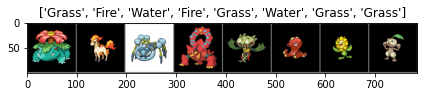

In [ ]:
dict_torch = {0:'Fire',1:'Grass',2:'Water'}

def imshow(img,label):
    img = img/2+0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(7,4))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    label_text = list(map(dict_torch.get,label.numpy()))
    plt.title(str(label_text))
    plt.show()

# Get some random training images
data_iter = iter(train_loader)
images,labels = data_iter.next()

# Show a batch of images
imshow(torchvision.utils.make_grid(images),labels)

### 10.3. Model Implementation

In [ ]:
# Training step
if __name__=='__main__':
  if torch.cuda.is_available():
    print('...Using GPU...')
  else:
    print('...Using CPU...')

  # Hyperparameters
  learning_rate = 0.01
  num_epochs = 200
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  # Model
  model = CNN(input_dims=(3,96,96)).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer =  optim.SGD(model.parameters(),lr=learning_rate)
  total_steps = len(train_loader)
  epoch_losses,step_losses = [],[]

  with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for epoch in range(num_epochs):
      step_loss = []
      for i,(images,labels) in enumerate(train_loader):
        imgs = images.to(device)
        labs = labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs,labs)
        step_loss.append(loss.item())
        step_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      if (epoch+1)%10 == 0:
        print('Epoch: {}/{}, Step: {}/{}, Loss: {}.'.format(str(epoch+1).zfill(3),num_epochs,i+1,total_steps,format(loss.item(),'.4f')))
      
      epoch_losses.append(np.mean(step_loss))

  print('...Training done...')

...Using GPU...
Epoch: 010/200, Step: 24/24, Loss: 1.2515.
Epoch: 020/200, Step: 24/24, Loss: 1.0279.
Epoch: 030/200, Step: 24/24, Loss: 0.4360.
Epoch: 040/200, Step: 24/24, Loss: 0.3242.
Epoch: 050/200, Step: 24/24, Loss: 0.2109.
Epoch: 060/200, Step: 24/24, Loss: 0.5749.
Epoch: 070/200, Step: 24/24, Loss: 0.1470.
Epoch: 080/200, Step: 24/24, Loss: 1.0025.
Epoch: 090/200, Step: 24/24, Loss: 0.0949.
Epoch: 100/200, Step: 24/24, Loss: 0.0156.
Epoch: 110/200, Step: 24/24, Loss: 0.0100.
Epoch: 120/200, Step: 24/24, Loss: 0.0005.
Epoch: 130/200, Step: 24/24, Loss: 0.0062.
Epoch: 140/200, Step: 24/24, Loss: 0.0119.
Epoch: 150/200, Step: 24/24, Loss: 0.0040.
Epoch: 160/200, Step: 24/24, Loss: 0.0276.
Epoch: 170/200, Step: 24/24, Loss: 0.0000.
Epoch: 180/200, Step: 24/24, Loss: 0.0016.
Epoch: 190/200, Step: 24/24, Loss: 0.0042.
Epoch: 200/200, Step: 24/24, Loss: 0.0005.
...Training done...


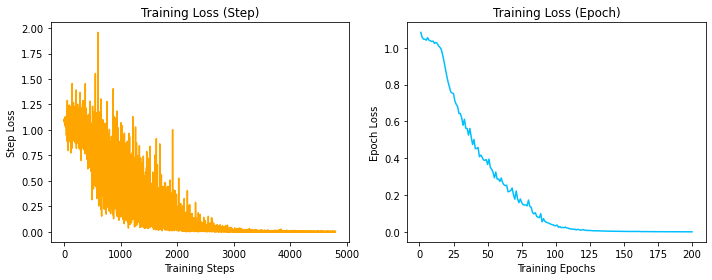

In [ ]:
# Plot the training progression
steps_array = np.array([i+1 for i in range(total_steps*num_epochs)])
epochs_array = np.array([i+1 for i in range(num_epochs)])

f,a = plt.subplots(1,2,figsize=(10,4))

sns.lineplot(x=steps_array,y=np.array(step_losses),color='orange',ax=a[0])
sns.lineplot(x=epochs_array,y=np.array(epoch_losses),color='deepskyblue',ax=a[1])
a[0].set_xlabel('Training Steps')
a[1].set_xlabel('Training Epochs')
a[0].set_ylabel('Step Loss')
a[1].set_ylabel('Epoch Loss')
a[0].set_title('Training Loss (Step)')
a[1].set_title('Training Loss (Epoch)')

plt.tight_layout()
plt.show()

### 10.4. Performance Assessment

In [ ]:
# Testing step
if __name__=='__main__':
  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(3)]
    n_class_samples = [0 for i in range(3)]

    for images,labels in test_loader:
      imgs = images.to(device)
      labs = labels.to(device)
      outputs = model(imgs)
      _,preds = torch.max(outputs,1)
      n_samples += labs.size(0)
      n_correct += (preds==labs).sum().item()

      if len(labs) == batch_size:
        for i in range(batch_size):
          lab = labs[i]
          pred = preds[i]
          if lab == pred:
            n_class_correct[lab] += 1
          n_class_samples[lab] += 1
      
    acc = n_correct/n_samples
    print('Accuracy score on the testing data is {}.'.format(acc))

Accuracy score on the testing data is 0.8125.


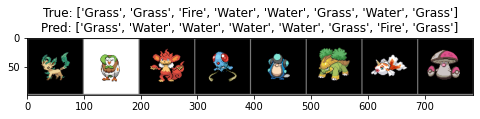

In [ ]:
def imshow_new(img,true_label,pred_label):
    img = img/2+0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,4))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    true_label_text = list(map(dict_torch.get,true_label.numpy()))
    pred_label_text = list(map(dict_torch.get,pred_label))
    plt.title('True:'+' '+str(true_label_text)+'\n'+'Pred:'+' '+str(pred_label_text))
    plt.show()

# Get some random testing images
data_iter_test = iter(test_loader)
images,labels = data_iter_test.next()

# Visualize prediction on random testing images
images_tensor = images.to(device)
output = model(images_tensor)
_,preds_tensor = torch.max(outputs,1)
preds = np.squeeze(preds_tensor.cpu().numpy())
imshow_new(torchvision.utils.make_grid(images),labels,preds)

## 11. Analysis Summary and Conclusion

### 11.1. Algorithm Comparison Summary

#### 11.1.1. Comparing Algorithm Performance

For both k-means and Gaussian mixture, using YCbCr images yield results that better match the true labels. And with YCbCr images, k-means achieves an accuracy score of 0.6822, higher than the Gaussian mixture's 0.6314. In addition to higher accuracy, k-means is also computationally cheaper than Gaussian mixture. Therefore, we conclude that k-means is the better clustering algorithm to use for this pokemon image clustering exercise.

11.1.2. Comparing Algorithm Results

For both algorithms, the cluster separation criterion seems to be brightness-related when using RGB images. This leads to a rather homogeneous intra-cluster label distribution. The separation criterion when using YCbCr images, however, seems to be color-related, which is more aligned with our initial conjecture that pokemon types are correlated with colors. 

### 11.2. Conclusion and Insights Summary

On the one hand, it is interesting to see that k-means is able to achieve an accuracy score on par with the support vector machine when using YCbCr images. This not only demonstrates the power of the algorithm but also highlights the importance of appropriate data preprocessing. 

On the other hand, the deep learning model achieves noticeably high accuracy even with limited training data and a relatively small model. This doesn't diminish the value of unsupervised learning exercises even when pre-assigned labels exist. In our initial exploration, using k-means or Gaussian mixture on the raw images leads to clustering outcomes that are based on the size of the pokemon. This shows that unsupervised learning can facilitate hidden commonality discovery, especially with more complex data sets. 
